In [1]:
from __future__ import print_function
import os
import json

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import chainer
from chainer.dataset import convert
import chainer.links as L
import chainer.functions as F
from chainer import serializers

import Augmentor
import easydict

import utils

Using TensorFlow backend.
/home/fytroo/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
from easydict import EasyDict
args = EasyDict({
    'bs': 64, 
    'epoch' : 100,
    'lr' : 0.05,
    'gpu': 0,
    'out': 'result',
    'resume': '',
    'n_in': 32, 
})
try:
    __file__.endswith('py')
    import argparse
    parser = argparse.ArgumentParser(description='Chainer example: MNIST')
    parser.add_argument('--batchsize', '-b', dest='bs', type=int, default=args.bs,
                        help='Number of images in each mini-batch')
    parser.add_argument('--epoch', '-e', type=int, default=args.epoch,
                        help='Number of sweeps over the dataset to train')
    parser.add_argument('--learningrate', '-l', dest='lr', type=float, default=args.lr,
                        help='Number of sweeps over the dataset to train')
    parser.add_argument('--frequency', '-f', type=int, default=-1,
                        help='Frequency of taking a snapshot')
    parser.add_argument('--gpu', '-g', type=int, default=args.gpu,
                        help='GPU ID (negative value indicates CPU)')
    parser.add_argument('--out', '-o', default=args.out,
                        help='Directory to output the result')
    parser.add_argument('--resume', '-r', default=args.resume,
                        help='Resume the training from snapshot')
    parser.add_argument('--unit', '-u', dest='n_in', type=int, default=args.n_in,
                        help='Number of units')
    parser.add_argument('--noplot', dest='plot', action='store_false',
                        help='Disable PlotReport extension')
    args = parser.parse_args()
except:
    print('no argsparse')
    pass

no argsparse


In [3]:
dataset_dir = 'flower_images'
df  = pd.DataFrame.from_csv(os.path.join(dataset_dir,'flower_labels.csv'))

df['name'] = df.index
df['path'] = dataset_dir + '/' + df['name']

n_label = df.label.drop_duplicates().count()
n_label
df

/home/fytroo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  


,label,name,path
file,,,
0001.png,0,0001.png,flower_images/0001.png
0002.png,0,0002.png,flower_images/0002.png
0003.png,2,0003.png,flower_images/0003.png
0004.png,0,0004.png,flower_images/0004.png
0005.png,0,0005.png,flower_images/0005.png
0006.png,1,0006.png,flower_images/0006.png
0007.png,6,0007.png,flower_images/0007.png
0008.png,0,0008.png,flower_images/0008.png
0009.png,0,0009.png,flower_images/0009.png


In [4]:
def load_fromdf(dataframe, resize=(96,96)):
    if type(resize) is int:
        resize = (resize, resize)
    
    df = dataframe
    x_data = []
    y_data = []
    for idx, row in df.iterrows():
        y = row['label']
        f = row['path']

        img = Image.open(f).resize(resize, Image.LANCZOS)
        img = img.convert('RGB')
        x = np.array(img)
        x_data.append(x)
        y_data.append(y)
    x_data = np.array(x_data)
    y_data = np.array(y_data)

    return x_data, y_data

In [5]:
df_train, df_test = utils.train_test_split_df(df, test_size=0.1)
x_train, y_train = load_fromdf(df_train, resize=args.n_in)
x_test, y_test = load_fromdf(df_test, resize=args.n_in)

x_train.shape

(200, 32, 32, 3)

In [11]:
class Fire(chainer.Chain):
    def __init__(self, n_in=None, n_out=32):
        super(Fire, self).__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(n_in, 32, 3)
            self.conv2 = L.Convolution2D(None, n_out, 3)
            self.bn = L.BatchNormalization(32)
            self.bn2 = L.BatchNormalization(32)
    
    def __call__(self, x):
        x = self.conv1(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.conv2(x)
        return x    

In [12]:
class LeNet(chainer.Chain):
    def __init__(self, n_in=32, n_out=10):
        super(LeNet, self).__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(None, 16, 3)
            self.fire1 = Fire(None, 32)
            self.fire2 = Fire(None, 64)
            self.fc = L.Linear(None, n_out)
    
    def __call__(self, x):
        x = self.conv1(x)
        x = self.fire1(x)
        x = F.average_pooling_2d(x, ksize=2, stride=2)
        x = self.fire2(x)
        x = F.average_pooling_2d(x, ksize=2, stride=2)
        x = self.fc(x)
        return x    

In [13]:
model = L.Classifier(LeNet(args.n_in, n_label),
                    lossfun=F.softmax_cross_entropy,
                    accfun=F.accuracy)
xp = np
if args.gpu >= 0:
    import cupy as cp
    xp = cp
    chainer.cuda.get_device_from_id(args.gpu).use()
    model.to_gpu()  # Copy the model to the GPU
optimizer = chainer.optimizers.MomentumSGD(args.lr)
optimizer.setup(model)

In [14]:
p = Augmentor.Pipeline()
p.flip_left_right(probability=0.5)
p.flip_top_bottom(probability=0.5)
g = p.keras_generator_from_array(x_train, y_train, batch_size=args.bs)
g = ((
    xp.array(np.swapaxes((x/255.), 1, 3)).astype(np.float32),
    xp.array(y.astype(np.int8))
    ) for (x,y) in g)

chainer.trainingを使わず，訓練ループをかく
chainer.trainingでは，自前のデータのイテレータを使うことができないため．
Augmentorを使いたい

In [15]:
def train(step=None):
    total_loss = 0
    total_acc = 0
    n_data = 0
    n_train = len(y_train)
    for _ in range(n_train//args.bs):
        xs, ts = next(g) 
        x = chainer.Variable(xs)
        t = chainer.Variable(ts)
        optimizer.update(model, x, t)
        loss = model(x,t)
        n_data += len(t.data)
        total_loss += float(loss.data) * len(t.data)
        total_acc += float(model.accuracy.data) * len(t.data)

    if step is None:
        print('step:{}\t loss: {:.4f}\t acc: {:.4f}'.format(step, total_loss/n_data, total_acc/n_data))
    else:
        print('loss: {:.4f}\t acc: {:.4f}'.format(total_loss/n_data, total_acc/n_data))

In [16]:
def test():
    xs = xp.array(np.swapaxes((x_test), 1, 3)).astype(np.float32)
    ts = xp.array(y_test).astype(np.int8)
    x = chainer.Variable(xs)
    t = chainer.Variable(ts)
    loss = model(x,t)

    n_data = len(t.data)
    total_loss = float(loss.data) * len(t.data)
    total_acc = float(model.accuracy.data) * len(t.data)

    print('val_loss: {:.4f}\t val_acc: {:.4f}'.format(total_loss/n_data, total_acc/n_data))

In [17]:
if __name__ == '__main__':
    for i in range(args.epoch):
        print('step:{}'.format(i))
        train()
        test()

step:0
step:None	 loss: 1.6588	 acc: 0.4635
val_loss: 2.7110	 val_acc: 0.1000
step:1
step:None	 loss: 1.4515	 acc: 0.5052
val_loss: 3.0060	 val_acc: 0.2000
step:2
step:None	 loss: 1.7867	 acc: 0.4479
val_loss: 4.7153	 val_acc: 0.2000
step:3
step:None	 loss: 1.6367	 acc: 0.4948
val_loss: 3.1951	 val_acc: 0.3000
step:4
step:None	 loss: 1.5765	 acc: 0.5417
val_loss: 3.8950	 val_acc: 0.2000
step:5
step:None	 loss: 1.5026	 acc: 0.5365
val_loss: 3.5863	 val_acc: 0.4000
step:6
step:None	 loss: 1.2639	 acc: 0.5521
val_loss: 2.4490	 val_acc: 0.3000
step:7
step:None	 loss: 1.1374	 acc: 0.6406
val_loss: 4.3937	 val_acc: 0.4000
step:8
step:None	 loss: 1.1947	 acc: 0.5990
val_loss: 3.2423	 val_acc: 0.3000
step:9
step:None	 loss: 1.0357	 acc: 0.6250
val_loss: 2.4293	 val_acc: 0.2000
step:10
step:None	 loss: 0.9876	 acc: 0.6615
val_loss: 3.7288	 val_acc: 0.2000
step:11
step:None	 loss: 0.9733	 acc: 0.6458
val_loss: 2.7362	 val_acc: 0.4000
step:12
step:None	 loss: 1.1165	 acc: 0.6146
val_loss: 1.9590	

In [14]:
result = json.load(open('result/log'))
df = pd.DataFrame(result)
df

,elapsed_time,epoch,iteration,main/accuracy,main/loss,validation/main/accuracy,validation/main/loss
0,0.667732,1,24,0.749583,109.704292,0.500000,362.686951
1,0.733289,2,48,0.827500,40.793514,0.500000,50.882755
2,0.798165,3,72,0.817500,25.645660,0.482143,12.118826
3,0.863760,4,96,0.804583,13.677096,0.553571,11.006830
4,0.930292,5,120,0.822917,4.003510,0.500000,51.122948
5,0.994253,6,144,0.825417,8.563640,0.500000,15.479998
6,1.058523,7,168,0.826667,4.063658,0.500000,7.898781
7,1.129458,8,192,0.791667,4.068286,0.500000,6.421888
8,1.196879,9,216,0.836667,1.219726,0.517857,1.158345
9,1.262754,10,240,0.888333,0.425228,0.500000,1.500370


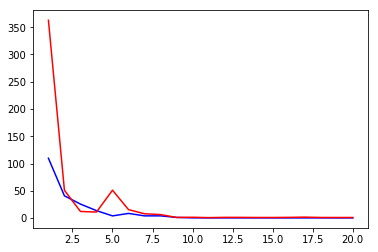

In [15]:
plt.plot(df['epoch'], df['main/loss'], color='blue')
plt.plot(df['epoch'], df['validation/main/loss'], color='red')
plt.show()

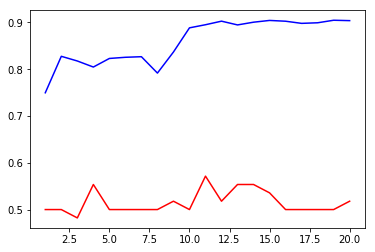

In [16]:
plt.plot(df['epoch'], df['main/accuracy'], color='blue')
plt.plot(df['epoch'], df['validation/main/accuracy'], color='red')
plt.show()